In [1]:
import matplotlib.pyplot as plt
import numpy as np

import os, random , time, sys, math
import warnings
warnings.filterwarnings("ignore")


import torch
from torch import optim, nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *
from torchvision.utils import make_grid

import torchvision
import torchvision.transforms as transforms

from IPython.display import clear_output

In [2]:
from libs.utilities import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Device = ", device)

Device =  cuda:1


In [3]:
## configuration

image_folder = "six_objects_1000stimuli/"

---
# Load images

In [4]:
import torchvision.transforms.functional as F
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

In [5]:
image_size = 64
batch_size = 128
trsfm=transforms.Compose([
    SquarePad(),
    transforms.Resize(image_size),
    #transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])


stim_ds     = torchvision.datasets.ImageFolder(  root=image_folder,   transform=trsfm    )
stim_loader = torch.utils.data.DataLoader(       
                                            stim_ds,   
                                            batch_size = batch_size,
                                            shuffle    = True
                                        )

print(f"Image folder classes {stim_ds.class_to_idx} ")

Image folder classes {'Apples': 0, 'digit2': 1, 'pizza': 2, 'tigers': 3} 


tensor([2, 3, 3, 2, 3, 2, 1, 2, 0, 2, 3, 1, 2, 1, 1, 0, 3, 3, 3, 0, 3, 1, 0, 0,
        2, 3, 3, 3, 1, 3, 0, 1, 0, 2, 3, 1, 1, 1, 0, 1, 0, 0, 0, 3, 1, 3, 1, 0,
        1, 3, 2, 2, 2, 1, 0, 3, 3, 2, 2, 0, 0, 1, 0, 3, 0, 3, 0, 3, 3, 0, 0, 0,
        2, 2, 2, 1, 2, 2, 1, 1, 1, 0, 3, 0, 1, 0, 3, 3, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 2, 0, 3, 2, 3, 0, 0, 0, 1, 3, 3, 1, 1, 0, 0, 1, 2, 0, 1, 1, 3, 0, 1,
        1, 3, 3, 2, 1, 2, 1, 0])


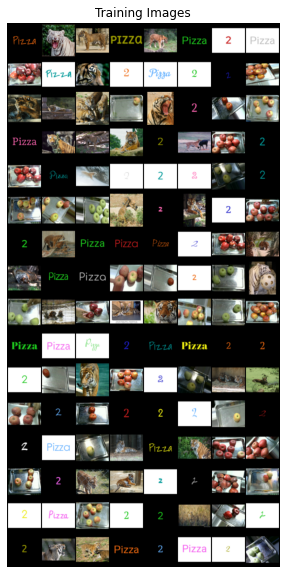

In [6]:
for img , label in stim_loader:
    print(label)
    
    break
    
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(img.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
##  Model

In [48]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=64, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1, kernel_size=4,
                stride=2, bias=False
            ),
            nn.Sigmoid()
        
        )
        


    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 1)
        # Flatten and apply sigmoid
 
        return x

#### ====================================================================

    
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)

In [65]:
# Custom weight initialization

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)


#Count the parameters for writing papers
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
     
                
# Instantiate networks

generator = GenerativeNet()
generator.apply(init_weights)
discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

In [66]:
print(generator)

print(f'The model {type(generator).__name__} has {count_parameters(generator):,} trainable parameters')# Train the model

GenerativeNet(
  (linear): Linear(in_features=100, out_features=16384, bias=True)
  (conv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (out): Tanh()
)
The model GenerativeNet has 12,672,768 trainabl

In [67]:
print(discriminator)

print(f'The model {type(discriminator).__name__} has {count_parameters(discriminator):,} trainable parameters')# Train the model

DiscriminativeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(

In [52]:


def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n



def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)


def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data



In [53]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [54]:


def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

def do_plot(data_dic, title="" ):
    plt.figure(figsize=(15,3))
    for _key, _val in data_dic.items():
        plt.plot( _val , label=_key)
    plt.title(title)
    plt.legend()
    plt.show()


In [55]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=( 0.5, 0.999 ))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(    0.5, 0.999  ))

# Loss function

loss = nn.BCELoss()

# Number of epochs of training
num_epochs = 50


d_errors  = []
g_errors  = []

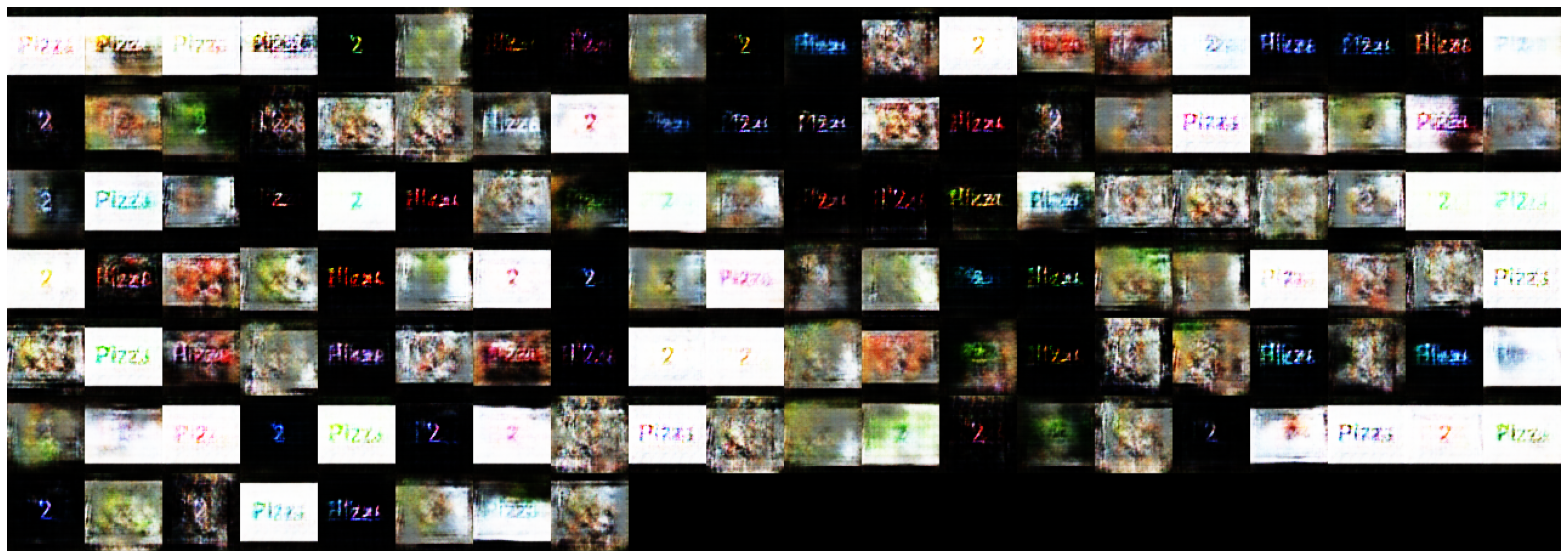

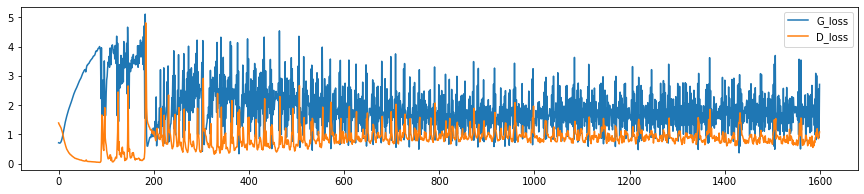

Epoch 49/50 Iteration : 30 | D_loss: 1.077548 | G_loss: 2.710275  	 | 


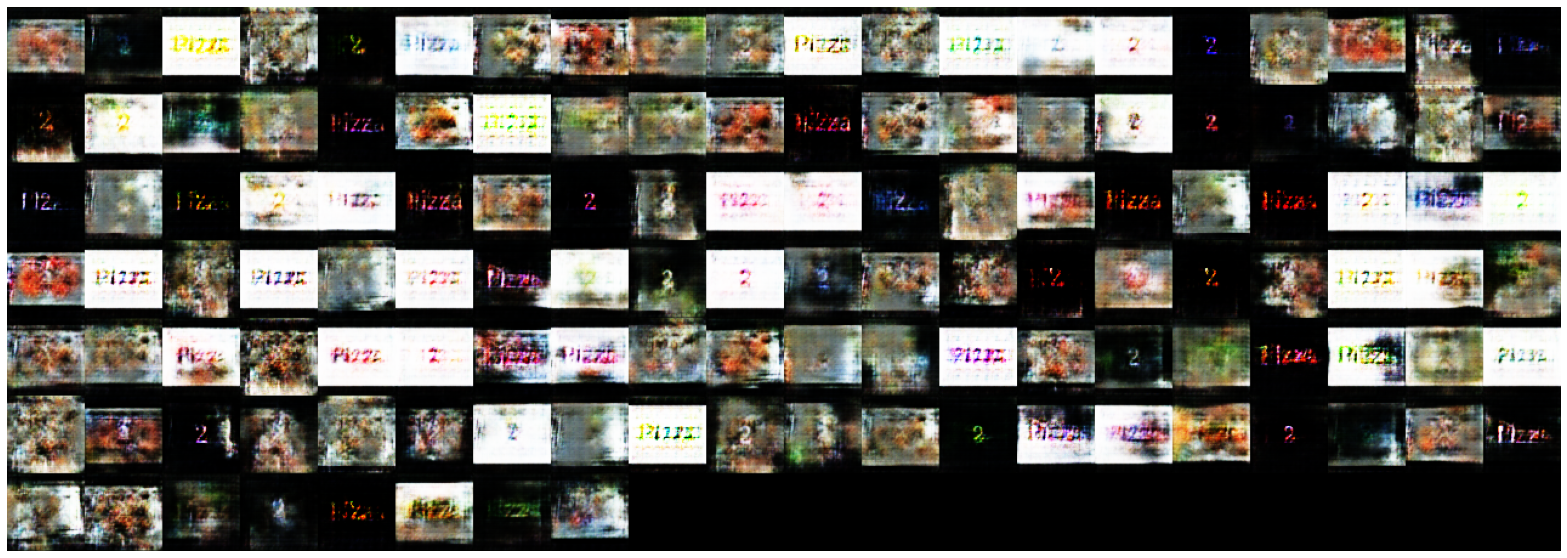

In [57]:
num_test_samples = 16
test_noise = noise(num_test_samples)

progress_update = 10


for epoch in range(num_epochs):
    for n_batch, (real_data,_) in enumerate(stim_loader):

        # Train Discriminator
        
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
        
#         print(type(d_error))
        
        d_errors.append( d_error.item() )
        # Train Generator
        fake_data = generator(noise(real_data.size(0)))
        g_error   = train_generator(g_optimizer, fake_data)
        g_errors.append(g_error.item() )

        
        if n_batch  %  progress_update == 0:
            clear_output(wait=True) 
            data_plot = {"G_loss" : g_errors, "D_loss": d_errors} 
            do_plot(data_plot)
            print(f'Epoch {epoch}/{num_epochs} Iteration : {n_batch} | D_loss: {d_error.item():.6f} | G_loss: {g_error.item() :.6f}  \t | ')
        
            grid     = make_grid(fake_data.detach().cpu(), nrow=20, normalize=True, padding=0)
            fig, ax  = plt.subplots(  figsize = (30,10)  )
            ax.imshow(grid.permute(1, 2, 0).data, cmap='binary')
            ax.axis('off')

        # Save model checkpoints

In [58]:

# dataset=[13, 22, 26, 38, 36, 42,49, 50, 77, 81, 98, 110]

dataset = np.array(d_errors) 
print('Mean:', np.mean(dataset))
print('Standard Deviation:', np.std(dataset))

Mean: 0.8518045165649918
Standard Deviation: 0.37096104370517435


In [62]:
### try to generatate new image by input the noise to generator

test_noise = noise(10)
print(test_noise.shape)
recon_image = generator(  test_noise ).detach()

torch.Size([10, 100])


(-0.5, 639.5, 63.5, -0.5)

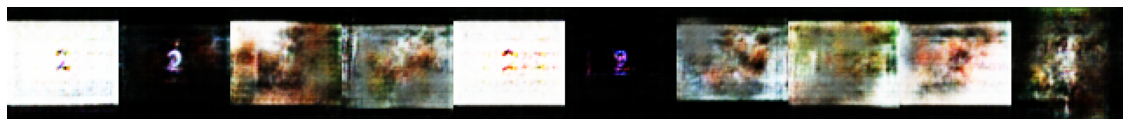

In [63]:

grid     = make_grid(recon_image.detach().cpu(), nrow=10, normalize=True, padding=0)
fig, ax  = plt.subplots(  figsize = (20,20)  )
ax.imshow(grid.permute(1, 2, 0).data, cmap='binary')
ax.axis('off')